# C3S Atlas notebooks

***

> This notebook reproduces the calculation of indices forming the dataset underpinning the Copernicus Interactive Climate Atlas (C3S Atlas, [https://atlas.climate.copernicus.eu/atlas](https://atlas.climate.copernicus.eu/atlas)) that is distributed by the CDS catalogue (https://cds.climate.copernicus.eu/). It is part of a notebook library produced for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0) and has been produced by IFCA-CSIC and Predictia for the C3S.
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

# Calculate tx35bals for CMIP6

This Jupyter Notebook calculates the index **tx35**  with bias adjusted (ba) using the linear scaling method based on Douglas Maraun 2016 (**tx35bals**) for the CMIP6-CMCC_ESM2 model (year 2080). **WFDE5** is used as reference dataset for the "ba". The results are compared with the "Copernicus Interactive Climate Atlas: gridded monthly dataset" (Task **C3S2_381_11**) produced using the workflow described in Deliverable **D381.1.3.1** which is available in the project's GitLab repository: https://gitlab.predictia.es/c3s-cica/data

Figure 1 shows the scheme of the workflow designed for data production in the context of the C3S Atlas. Note that bias adjustment includes implicitly a change of grid (from the GCM to the observations) but this is not indicated as a regridding operation.

To calculate an index:
 - Download climate data from the C3S-CDS using the CDS API.
   
 - Download the reference datasets (**only for bias adjusted indices**).
 - Perform data homogenization to ensure the same calendar time, coordinate names, variable units, dimension order, among other things.
 - Interpolate both the projections and the reference dataset to a regular-common grid using conservative remapping (**only for bias adjusted indices**).
 - Calculate the index.
 - Perform temporal aggregation.
 - Interpolate to a regular-common grid using conservative remapping (**only for no bias adjusted indices**)

![C3S Atlas workflow](workflow.png)

**<span style="color:red">Please be advised that downloading the required data for this script may take several minutes.</span>**

### Load Python packages and clone and install the **user-tools** repository from the C3S Atlas GitLab repository

Clone (`git clone`) the [C3S-Atlas-user-tools](https://gitlab.predictia.es/c3s-cica/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the requirements section of the README: https://gitlab.predictia.es/c3s-cica/c3s-atlas#requirements

In [12]:
import cdsapi
import os
from pathlib import Path
import xarray as xr
import xclim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob

from c3s_atlas.software.utils import (
    extract_zip_and_delete,
    get_ds_to_fill,
    plot_month
)
from c3s_atlas.software.fixers import (
    apply_fixers
)
import c3s_atlas.software.interpolation as xesmfCICA

### Dowload climate data with the CDS API
- Catalogs: 
    - CMIP6: [https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview)
    - WFDE5: [https://cds.climate.copernicus.eu/cdsapp#!/dataset/derived-near-surface-meteorological-variables?tab=overview](https://cds.climate.copernicus.eu/cdsapp#!/dataset/derived-near-surface-meteorological-variables?tab=overview)

- How to use the CDS API: [https://cds.climate.copernicus.eu/api-how-to](https://cds.climate.copernicus.eu/api-how-to)

In [22]:
# define some global attributes for the CDS-API
CMIP6_years = {
    "historical": [str(n) for n in np.arange(2005, 2006)],
    "ssp5_8_5": ["2080"]
}
# variables
variables = {
    'tx': 'daily_maximum_near_surface_air_temperature',
}
# directory to download the files
file_dest_CMIP6 = Path('./data/CMIP6')
file_dest_WFDE5 = Path('./data/WFDE5')

In [15]:
months = [
    '01', '02', '03',
    '04', '05', '06',
    '07', '08', '09',
    '10', '11', '12'
]
        
days = [
    '01', '02', '03',
    '04', '05', '06',
    '07', '08', '09',
    '10', '11', '12',
    '13', '14', '15',
    '16', '17', '18',
    '19', '20', '21',
    '22', '23', '24',
    '25', '26', '27',
    '28', '29', '30', '31'
]

In [16]:
c = cdsapi.Client()

#### Download CMIP6 data 
- Year 2080 for the ssp5_8_5 scenario
- Period 1980-2006 for the historical scenario.

In [ ]:
os.makedirs(file_dest_CMIP6, exist_ok=True)

for experiment in CMIP6_years.keys():
    for year in CMIP6_years[experiment]:
        for var in variables.keys():
            path_zip = file_dest_CMIP6 / f"CMIP6_{var}_{experiment}_{year}.zip"
            c.retrieve(
                'projections-cmip6',
                {
                    'format': 'zip',
                    'temporal_resolution': 'daily',
                    'variable': variables[var],
                    'experiment': experiment,
                    'model': 'cmcc_esm2',
                    'year': [year],
                    'month': months,
                    'day': days,
                    'area':[45.5, 5.5, 34, -11.5], # crop area for Spain
                },
                path_zip)
            # Extract zip file into the specified directory and remove zip
            extract_zip_and_delete(path_zip) 

#### Download WFDE5 data 
- Period 1980-2006

In [17]:
# variables
variables = {
    't': 'near_surface_air_temperature',
}

In [ ]:
os.makedirs(file_dest_WFDE5, exist_ok=True)

for year in CMIP6_years['historical']:
    for month in months:
        for var in variables.keys():
            path_zip = file_dest_WFDE5 / f"WFDE5_{var}_{year}_{month}_globe.zip"
            c.retrieve(
                'derived-near-surface-meteorological-variables',
                {
                    'version': '2_1',
                    'month': month,
                    'reference_dataset': 'cru',
                    'variable': 'near_surface_air_temperature',
                    'year': year,
                }).download(path_zip)
            # Extract zip file into the specified directory and remove zip
            extract_zip_and_delete(path_zip)
            # Crop area an save
            ds = xr.open_dataset(path_zip.with_suffix(".nc"))
            ds = ds.sel(lat = slice(34, 45.5), lon = slice(-11.5 , 5.5))
            file = file_dest_WFDE5 / f"WFDE5_{var}_{year}_{month}.nc"
            ds.to_netcdf(file)
            os.remove(path_zip.with_suffix(".nc"))

### Load files with xarray

- https://docs.xarray.dev/en/stable/

In [24]:
# load CMIP6 files
ds_CMIP6_hist = xr.open_mfdataset(
    np.sort(glob.glob(str(file_dest_CMIP6 / "*tx_historical*.nc"))), 
    concat_dim='time', combine='nested'
)

ds_CMIP6_ssp585 = xr.open_mfdataset(
    np.sort(glob.glob(str(file_dest_CMIP6 / "*tx_ssp5_8_5*.nc"))), 
    concat_dim='time', combine='nested'
)
# load WFDE5 files
ds_WFDE5_hist = xr.open_mfdataset(
    np.sort(glob.glob(str(file_dest_WFDE5 / "*WFDE5_t*.nc"))), 
    concat_dim='time', combine='nested'
)

### Homegenization
Once the data is downloaded from the CDS it undergoes a process of homogenization:
- The metadata of the **spatial coordinates** is homogenised to use standard names, in particular [lon, lat].
  
- Fix any non-standard **calendars** used in the data. This typically involves converting the calendars to the CF standard calendar (Mixed Gregorian/Julian) commonly used in climate data. 
- Convert the **units** of the data to a common format (e.g. Celsius for temperature). This prevents us from working with the same variables in different units, for example.
- Convert the **longitude** values from the [0, 360] format to the [-180, 180] one. This is done to ensure that the longitude variable is common between the different datasets.
- **Aggregated to the required temporal resolution**. For example, hourly datasets (such as ERA5, ERA5-Land, WFDE5, etc.) will be resampled to daily resolution. This involves using a temporal aggregation method, such as taking the maximum or minimum value for a given variable. As part of this last step, some variable transformations are necessarily applied. For instance, fluxes variables in ERA5 are accumulated, and therefore, the last hour of the day represent daily accumulations. To mention another case, the surface wind is computed as a combination of both the u- and v-components.

In [25]:
project_id = "cmip6"
variable = 'tasmax'
var_mapping = {
            "dataset_variable": {"tasmax": "tasmax"},
            "aggregation": {"tasmax": "mean"},
        }
ds_CMIP6_hist = apply_fixers(ds_CMIP6_hist, variable, project_id, var_mapping)
ds_CMIP6_ssp585 = apply_fixers(ds_CMIP6_ssp585, variable, project_id, var_mapping)

2024-12-06 17:41:41,984 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2024-12-06 17:41:42,145 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 11MB
Dimensions:    (time: 9490, bnds: 2, lat: 12, lon: 14)
Coordinates:
  * time       (time) object 76kB 1980-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat        (lat) float64 96B 34.4 35.34 36.28 37.23 ... 42.88 43.82 44.76
  * lon        (lon) float64 112B -11.25 -10.0 -8.75 -7.5 ... 1.25 2.5 3.75 5.0
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 2MB dask.array<chunksize=(365, 12, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 2MB dask.array<chunksize=(365, 14, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 6MB dask.array<chunksize=(1, 12, 14), meta=np.ndarray>
Attributes: (12/4

In [26]:
project_id = "WFDE5"
variable = 'tasmax'
var_mapping = {
            "dataset_variable": {"tasmax": "Tair"},
            "aggregation": {"tasmax": "maximum"},
        }
ds_WFDE5_hist = apply_fixers(ds_WFDE5_hist, variable, project_id, var_mapping)

2024-12-06 17:41:42,827 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2024-12-06 17:41:42,956 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 715MB
Dimensions:  (time: 227928, lat: 23, lon: 34)
Coordinates:
  * time     (time) datetime64[ns] 2MB 1980-01-01 ... 2005-12-31T23:00:00
  * lon      (lon) float64 272B -11.25 -10.75 -10.25 -9.75 ... 4.25 4.75 5.25
  * lat      (lat) float64 184B 34.25 34.75 35.25 35.75 ... 44.25 44.75 45.25
Data variables:
    Tair     (time, lat, lon) float32 713MB dask.array<chunksize=(744, 23, 34), meta=np.ndarray>
Attributes:
    title:        WATCH Forcing Data methodology applied to ERA5 data
    institution:  Copernicus Climate Change Service
    contact:      http://copernicus-support.ecmwf.int
    comment:      Methodology implementation for ERA5 and dataset production ...
    Conventions:  CF-1.7
    summary:      ERA5 data regridded to half degree regular lat-lon; Genuine...
  

### Interpolate to a common and regular grid using xESMF 
A wrapper for the [xESMF](https://xesmf.readthedocs.io/en/stable/) Python package was developed within the framework of the C3S Atlas project to extend its functionalities to all datasets (regular, curvilinear, etc.)

In [27]:
# interpolate data
int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : np.arange(34.5, 46.5, 1),
            'lons' : np.arange(-11.5, 6.5, 1),
            'var_name' : 'tasmax'
}

In [28]:
INTER = xesmfCICA.Interpolator(int_attr)

In [ ]:
ds_CMIP6_hist_i = INTER(ds_CMIP6_hist)
ds_CMIP6_ssp585_i = INTER(ds_CMIP6_ssp585)
ds_WFDE5_hist_i = INTER(ds_WFDE5_hist)

### Bias adjusted using ibicus
Two methods of **ba** are applied in the C3S Atlas: the [LinearScaling](https://ibicus.readthedocs.io/en/latest/reference/debias.html#ibicus.debias.LinearScaling) (Douglas Maraun 2016) and the [ISIMIP](https://ibicus.readthedocs.io/en/latest/reference/debias.html#ibicus.debias.ISIMIP) (Lange 2019). Here, for simplicity, we applied the linear scaling one.

- https://pypi.org/project/ibicus/

In [30]:
from ibicus.debias import LinearScaling

In [ ]:
# The same cofiguration as bellow is used in the C3S Atlas. 
# It implied that the Linear scaling method is applied month by month.
args = {
    "running_window_mode" : True,
    "running_window_length" : 30,
    "running_window_step_length" : 30
}

debiaser_obj = LinearScaling.from_variable(
    variable = 'tasmax', 
    **args
)

In [ ]:
ba_data = debiaser_obj.apply(
    obs = ds_WFDE5_hist_i['tasmax'].values,
    cm_hist = ds_CMIP6_hist_i['tasmax'].values,
    cm_future = ds_CMIP6_ssp585_i['tasmax'].values,
)

In [33]:
ds_bias = get_ds_to_fill("tasmaxbals", target = ds_CMIP6_ssp585_i, reference = ds_CMIP6_ssp585_i)
ds_bias = ds_bias.transpose("time", "lat", "lon")
ds_bias["tasmaxbals"][:] = ba_data
ds_bias["tasmaxbals"].attrs["units"] = "Celsius" # xclim needs the atrribute units

### Calculate index (tx35) and aggregate to monthly (MS) temporal resolution using xclim

- https://xclim.readthedocs.io/en/stable/
- https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In [34]:
da_tx35bals = xclim.indices.tx_days_above(ds_bias['tasmaxbals'], 
                                          thresh='35.0 degC', freq='MS', op='>')

In [35]:
# Convert DataArray to Dataset with specified variable name
da_tx35bals = da_tx35bals.to_dataset(name='tx35bals')

### Compare the results with the "Copernicus Interactive Climate Atlas: gridded monthly dataset"

- Catalog: [Copernicus Interactive Climate Atlas: gridded monthly dataset](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)

In [36]:
project = "CMIP6"
scenario = "ssp585"
var = 'pr'
# directory to download the files
dest = Path('./data/CMIP6')
os.makedirs(dest, exist_ok=True)

##### Download SSP scenario

In [ ]:
filename = 'tx35bals_CMIP6_ssp585_mon_201501-210012.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'ssp5_8_5',
    'domain': 'global',
    'variable': 'monthly_count_of_days_with_bias_adjusted_maximum_temperature_above_35_c',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

In [43]:
# load data with xarray
ds_tx35bals_C3S_Atlas = xr.open_dataset(dest / "tx35bals_CMIP6_ssp585_mon_201501-210012.nc")

In [44]:
# select member (note than member names in the "Copernicus Interactive Climate Atlas: gridded monthly dataset" 
# are remappend to follow the DRS as much as possible)
select_member = [
    str(mem.data) for mem in ds_tx35bals_C3S_Atlas.member_id if "cmcc-esm2" in str(mem.data).lower()
][0]
print(select_member)

CMCC_CMCC-ESM2_r1i1p1f1


In [45]:
ds_tx35bals_C3S_Atlas_member_year = ds_tx35bals_C3S_Atlas.sel(
    member = np.where(ds_tx35bals_C3S_Atlas.member_id == select_member)[0], 
    time = "2080"
)

#### Plot results for one month

In [46]:
zoomin_extent = [-9.5, 3.5, 35.5, 44.5]

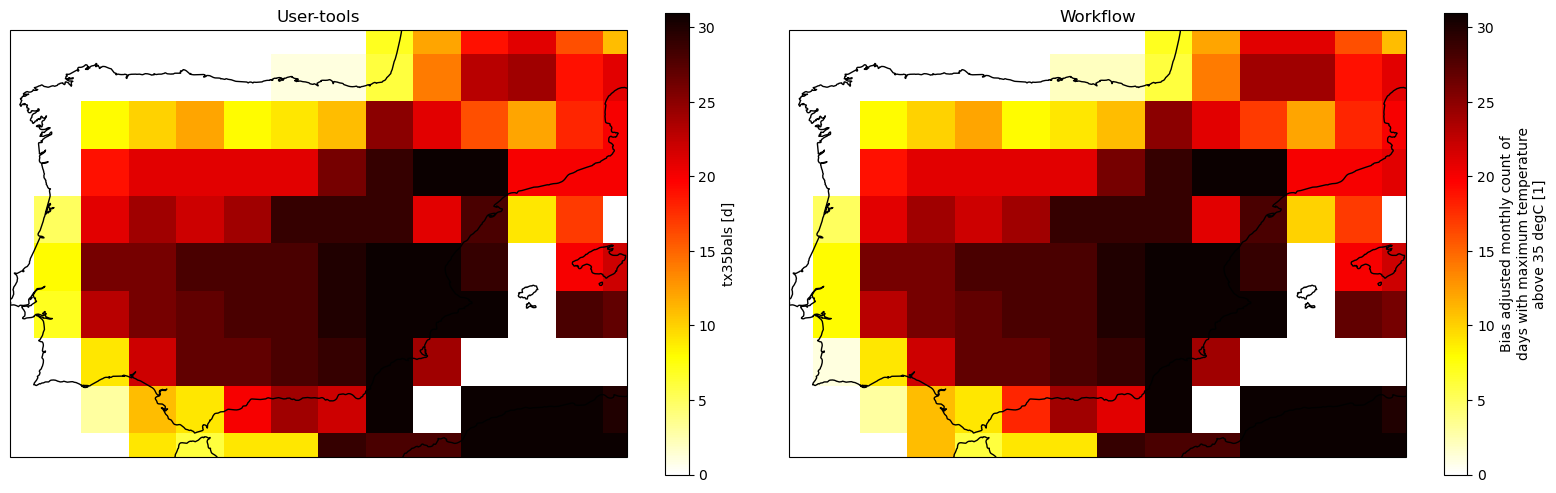

In [47]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': proj}, figsize=(20, 6))
# user-tools
plot_month(ax[0], da_tx35bals, 'tx35bals', 8, 'User-tools', 'hot_r')
ax[0].set_extent(zoomin_extent)
# workflow (intermediate dataset)
plot_month(ax[1], ds_tx35bals_C3S_Atlas_member_year, 'tx35bals', 8, 'Workflow', 'hot_r')
ax[1].set_extent(zoomin_extent)
plt.subplots_adjust(wspace=0.01, hspace=0.1) 